# Introduction to Machine Learning for  Pharmacology

## Task: Predict Lab of Origin

---

## Model 1: CNN + softmax

### 1. Import packages

In [1]:
import os
import functools
from typing import *
from glob import glob
import pickle

import torch
import numpy as np
import pandas as pd

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataloader import DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.features import Manifold
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from altlabs.index_mapping import create_index_mapping
from altlabs.dataset import (
    noop,
    random_roll,
    _convert_to_indices,
    SoftmaxDataset,
    limit_sequence_size,
    get_random_piece,
    FactorizationDataset,
)
from altlabs.torch.data import FasterBatchSampler, NoAutoCollationDataLoader
from altlabs.utils import Pipeline
from pytorch_lightning import seed_everything
from sklearn.metrics import top_k_accuracy_score

from sklearn.metrics import confusion_matrix
# %matplotlib inline

### 2. Load model(s)
- CNN + softmax
- CNN + Triplet

In [ ]:
softmax_model_paths = list(sorted(glob("../data/output/56836160-1c29-4909-814d-b37d77e86ffc/tensorboard_logs_csv_logs/*/checkpoints/*.ckpt")))
lab_index_mapping_paths = list(sorted(glob("../data/output/56836160-1c29-4909-814d-b37d77e86ffc/tensorboard_logs_csv_logs/*/lab_index_mapping.pkl")))
# from altlabs.model.conv1d_attn_softmax_classifier import Conv1dAttnSoftmaxClassifier, ModelConfig
# for loading the mode, we need to move .au directory to the root path of git which is capsule-3003146
from altlabs.model.conv1d_attn_softmax_classifier import Conv1dAttnSoftmaxClassifier, ModelConfig

### 3. Set data and results paths and load data

In [3]:
DATA_PATH = "../data/"
RESULTS_PATH = "../results/"

device = torch.device("cpu")

train_values_df = pd.read_csv(f"{DATA_PATH}train_values_grouped.csv")
train_labels_df = pd.read_csv(f"{DATA_PATH}train_labels.csv")
format_df = pd.read_csv(f"{DATA_PATH}format.csv")
test_values_df = pd.read_csv(f"{DATA_PATH}test_values.csv")
test_set = pd.read_csv(f"{DATA_PATH}test_labels.csv")
pub_id = pd.read_csv(f"{DATA_PATH}pubsubidx.csv")

pub_index = pub_id[pub_id.public==True].index
private_index = pub_id[pub_id.public==False].index

# sample the data for prediction
sample_size = 20
# sample_frac = 0.01
test_values_df_sampled = test_values_df.sample(sample_size,random_state=42)
test_set_sampled = test_set.iloc[test_values_df_sampled.index]

In [13]:
# create lab_id:lab_num mapping
lab_ids = test_set.columns[1:]

lab_num_mapping = {lab_id: f'Lab_{i+1:04d}' for i, lab_id in enumerate(lab_ids)}

# display(lab_num_mapping)


{'00Q4V31T': 'lab_0001',
 '012VT4JK': 'lab_0002',
 '028IO5W2': 'lab_0003',
 '03GRNN7N': 'lab_0004',
 '03Y3W51H': 'lab_0005',
 '09MQV1TY': 'lab_0006',
 '0A4AHRCT': 'lab_0007',
 '0A9M05NC': 'lab_0008',
 '0B9GCUVV': 'lab_0009',
 '0CL7QVG8': 'lab_0010',
 '0CML4B5I': 'lab_0011',
 '0DTHTJLJ': 'lab_0012',
 '0FFBBVE1': 'lab_0013',
 '0HWCWFNU': 'lab_0014',
 '0L3Y6ZB2': 'lab_0015',
 '0M44GDO8': 'lab_0016',
 '0MDYJM3H': 'lab_0017',
 '0N3V9P9M': 'lab_0018',
 '0NP55E93': 'lab_0019',
 '0PJ91ZT6': 'lab_0020',
 '0R296F9R': 'lab_0021',
 '0T2AZBD6': 'lab_0022',
 '0URA80CN': 'lab_0023',
 '0VRP2DI6': 'lab_0024',
 '0W6O08VX': 'lab_0025',
 '0WHP4PPK': 'lab_0026',
 '0XPTGGLP': 'lab_0027',
 '0XS4FHP3': 'lab_0028',
 '0Y24J5G2': 'lab_0029',
 '10TEBWK2': 'lab_0030',
 '11TTDKTM': 'lab_0031',
 '131RRHBV': 'lab_0032',
 '13LZE1F7': 'lab_0033',
 '14PBN8C2': 'lab_0034',
 '15D0Z97U': 'lab_0035',
 '15S88O4Q': 'lab_0036',
 '18C9J8EH': 'lab_0037',
 '19CAUKJB': 'lab_0038',
 '1AP294AT': 'lab_0039',
 '1B9BJ2IP': 'lab_0040',


In [14]:
# show input
test_values_df_sampled

,sequence_id,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
8310,WZAMN,TTCTTGAAGACGAAAGGGCCTCGTGATACGCCTATTTTTATAGGTT...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17684,UNQVV,ACGCGGCCGCCAGCTGAAGCTTCGTACGCTGCAGGTCGACGGATCC...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5222,0UZOL,TCACCGACCTCTCTCCCCAGGGGCTAGCATCGATGGATCAACAAGT...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12559,UMLP9,GGCAGTTCCCTACTCTCGCGTTAACGCTAGCATGGATGTTTTCCCA...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10986,IPFNO,GATCTCGATCCCGCGAAATTAATACGACTCACTATAGGGAGACCAC...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2425,0348B,TGGACGAGAAGACCACCGGCTGGCGGGGCGGCCACGTGGTGGAGGG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9703,0261R,TAGTTATTAATAGTAATCAATTACGGGGTCATTAGTTCATAGCCCA...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5833,CJLTL,TTGTACAAAGTTGGCATTATAAGAAAGCATTGCTTATCAATTTGTT...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17623,O4J10,GACGGATCGGGAGATCTCCCGATCCCCTATGGTGCACTCTCAGTAC...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12881,0VP4N,CCTGCAGGCAGCTGCGCGCTCGCTCGCTCACTGAGGCCGCCCGGGC...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 4. Data preprocesse
delete labs if there are less than 1 sequence belonging to them in the training set

In [16]:
transform_sequence_fn = Pipeline(
    random_roll,
    functools.partial(limit_sequence_size, limit=1000))


In [24]:
sequence_index_mapping = create_index_mapping(
    "ATGC", include_unkown=True, include_none=False,
)
sequence_index_mapping["N"] = 0

input_columns = train_values_df.drop(columns=["sequence_id", "groups", "output"]).columns
output_columns = train_labels_df.drop(columns=["sequence_id"]).columns
occurrences = np.sum(train_labels_df[output_columns].values, axis=0)
minimum_occurrences = 1
filtered_out_output_columns = output_columns[
    occurrences < minimum_occurrences
]
output_columns = output_columns.drop(filtered_out_output_columns)

In [25]:
output_columns

Index(['00Q4V31T', '012VT4JK', '028IO5W2', '03GRNN7N', '03Y3W51H', '09MQV1TY',
       '0A4AHRCT', '0A9M05NC', '0B9GCUVV', '0CL7QVG8',
       ...
       'ZQNGGY33', 'ZSHS4VJZ', 'ZT1IP3T6', 'ZU6860XU', 'ZU6TVFFU', 'ZU75P59K',
       'ZUI6TDWV', 'ZWFD8OHC', 'ZX06ZDZN', 'ZZJVE4HO'],
      dtype='object', length=1314)

In [26]:
# show filled out labs (you can increase the minimum_occurences)
# thinking about achieving it in an interactive way
fooc = pd.DataFrame(filtered_out_output_columns)
fooc.rename(columns={0:'filtered_out_labs'}, inplace=True)
fooc['lab_num'] = fooc['filtered_out_labs'].map(lab_num_mapping)
fooc

,filtered_out_labs,lab_num


### 5. Inference

In [27]:
seed_everything(350)

def predict_dataset(model: Conv1dAttnSoftmaxClassifier, dataset: FactorizationDataset, tta_steps: int) -> np.ndarray:
    batch_sampler = FasterBatchSampler(
        dataset, 32, shuffle=False,
    )

    model.to(device)
    predictions: List[List[float]] = []
    with torch.no_grad():
        for indices in batch_sampler:
            if tta_steps > 0:
                tta_predictions = []
                for i in range(tta_steps):
                    batch = dataset[indices]
                    if isinstance(batch[0], tuple):
                        (sequences, extra_inputs, _) = batch[
                            0
                        ]  # type: (torch.Tensor, torch.Tensor, torch.Tensor)
                    else:
                        (sequences, extra_inputs) = batch
                    outputs = torch.nn.functional.softmax(model(
                        sequences.to(device), extra_inputs.to(device)
                    )).tolist()
                    tta_predictions.append(np.array(outputs))
                predictions.extend(
                    np.mean(np.array(tta_predictions), axis=0).tolist()
                )
            else:
                batch = dataset[indices]
                if isinstance(batch[0], tuple):
                    (sequences, extra_inputs, _) = batch[
                        0
                    ]  # type: (torch.Tensor, torch.Tensor, torch.Tensor)
                else:
                    (sequences, extra_inputs) = batch
                outputs = torch.nn.functional.softmax(model(
                    sequences.to(device), extra_inputs.to(device)
                )).tolist()
                predictions.extend(outputs)

    return np.array(predictions)

In [28]:
os.chdir('/home/jovyan/Gene-Technology-HS2023/data')

In [29]:
%%time

fold_output = []
for softmax_model_path in softmax_model_paths:
    model = Conv1dAttnSoftmaxClassifier.load_from_checkpoint(softmax_model_path)
    model.model_config.positional_encoding = True
    
    dataset = SoftmaxDataset(
        test_values_df_sampled, # only for the showcase, for the exact resulst replace it with test_values_df
        sequence_index_mapping,
        input_columns,
        transform_sequence_fn=transform_sequence_fn,
        test=True,
        bpe=True,
    )
    outputs = predict_dataset(model, dataset, 10)
    fold_output.append(outputs)
final_outputs = np.mean(fold_output, axis=0)


df = pd.DataFrame(
    data=final_outputs, columns=output_columns, index=test_values_df_sampled["sequence_id"]
)


for column in filtered_out_output_columns:
    df[column] = 0.0
df = df[format_df.drop(columns=["sequence_id"]).columns]

In [30]:
# generate softmax output for pub and private sub sets
df = df.reset_index()
df.index = test_values_df_sampled.index
pub_best_sub = df[df.index.isin(pub_index)]
private_best_sub = df[df.index.isin(private_index)]

In [33]:
# the direct output after softmax
new_column_names = {col: lab_num_mapping[col] for col in df.columns if col in lab_num_mapping}
df.rename(columns=new_column_names, inplace=True)
df

,sequence_id,lab_0001,lab_0002,lab_0003,lab_0004,lab_0005,lab_0006,lab_0007,lab_0008,lab_0009,...,lab_1305,lab_1306,lab_1307,lab_1308,lab_1309,lab_1310,lab_1311,lab_1312,lab_1313,lab_1314
8310,WZAMN,4.927284e-08,3.367102e-07,1.566006e-08,1.487409e-11,1.108913e-08,1.105014e-02,3.414662e-06,1.411557e-08,3.597358e-05,...,1.186745e-08,3.339455e-07,2.933787e-09,4.127721e-08,9.807800e-06,3.619110e-07,9.118203e-02,1.710770e-08,2.491199e-08,7.777241e-07
17684,UNQVV,6.904827e-08,4.057790e-06,4.081471e-08,3.059166e-11,4.401265e-07,2.970448e-06,3.378922e-06,1.579111e-06,1.885030e-05,...,1.931012e-06,2.169305e-08,4.093123e-07,8.963612e-06,5.438586e-04,7.803440e-09,2.817830e-05,1.792693e-08,1.289687e-08,9.764901e-07
5222,0UZOL,1.846562e-11,2.882353e-12,4.186958e-12,3.399582e-10,1.122002e-09,7.647168e-07,1.029850e-03,2.605144e-08,5.201670e-08,...,8.096266e-07,9.328997e-11,1.056526e-07,3.508762e-12,2.362854e-11,1.283329e-12,7.719461e-11,1.863183e-10,9.747260e-12,3.864348e-03
12559,UMLP9,1.739161e-06,1.220424e-06,1.891609e-07,1.010026e-06,9.280404e-07,2.735980e-09,5.556804e-09,5.031080e-07,5.360828e-05,...,3.994518e-05,5.713278e-08,1.406214e-05,6.726715e-09,1.158606e-07,1.141397e-06,4.831424e-09,2.424815e-06,2.341968e-08,9.351758e-07
10986,IPFNO,3.484971e-04,2.219632e-06,3.652433e-06,5.623013e-11,1.376710e-06,2.132523e-06,4.982782e-07,1.351024e-04,5.252574e-05,...,1.063534e-06,1.392438e-06,2.581500e-07,3.530293e-07,3.673724e-04,4.684765e-09,4.045990e-03,5.010240e-06,3.951369e-06,4.574589e-06
2425,0348B,7.727694e-05,9.976648e-05,4.662279e-03,9.394424e-05,7.557272e-02,1.745131e-06,5.750984e-08,1.900497e-04,3.494579e-05,...,3.462983e-05,1.323961e-06,3.475762e-04,2.016365e-06,4.388523e-07,2.510353e-08,5.584665e-06,1.069915e-04,7.626585e-06,2.603118e-07
9703,0261R,1.920809e-10,6.021272e-08,4.131068e-10,1.804869e-10,3.890591e-07,1.851955e-07,2.259121e-07,1.288718e-06,1.281971e-05,...,9.927587e-09,1.131619e-07,1.523041e-07,1.085968e-09,1.073888e-03,1.280320e-07,1.173495e-08,2.002697e-10,3.159635e-09,5.296616e-08
5833,CJLTL,5.927895e-08,2.205759e-07,2.091082e-08,3.746405e-08,1.319541e-06,3.386411e-07,1.524105e-09,2.666477e-10,7.350013e-05,...,6.673179e-08,2.308035e-05,1.839852e-07,2.050131e-09,1.750836e-06,4.999223e-07,5.955482e-08,2.434984e-10,1.414882e-06,1.218558e-08
17623,O4J10,2.403057e-10,5.540171e-08,6.555600e-09,8.443815e-10,5.392507e-06,1.093645e-02,1.886301e-04,4.638696e-09,3.143818e-08,...,4.572128e-09,1.537462e-05,4.182163e-08,9.573262e-08,2.868137e-06,2.524210e-06,4.163538e-09,1.453075e-08,8.642073e-10,3.401416e-05
12881,0VP4N,8.786844e-07,1.626772e-07,9.467278e-09,6.215940e-09,1.229319e-06,2.917495e-05,1.833808e-03,1.359993e-03,1.049927e-06,...,1.548427e-04,1.322418e-06,7.652348e-10,4.716197e-09,1.597377e-05,1.615712e-08,7.653374e-07,1.463325e-08,3.082579e-10,2.534792e-06


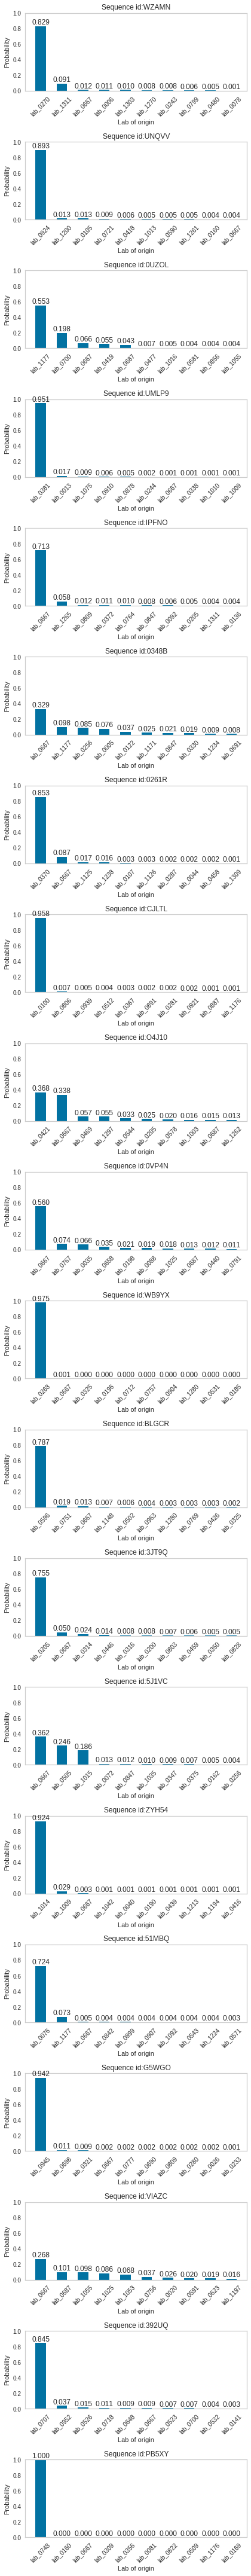

In [40]:
# Exclude the 'sequence_id' column from sorting
sort_columns = [col for col in df.columns if col != 'sequence_id']

# Sort columns for each row and keep top ten columns
sorted_columns = df.apply(lambda row: sorted(zip(row[sort_columns].index, row[sort_columns]), key=lambda x: x[1], reverse=True)[:10], axis=1)
# sorted_columns = sorted_columns.reset_index().drop(columns='index')
sorted_columns = pd.DataFrame(sorted_columns)

# Create a figure and axes
fig, axes = plt.subplots(sorted_columns.shape[0], 1, figsize=(6, sorted_columns.shape[0]*3))

# Iterate over each row and create a separate plot
for idx,(index , sorted_vals) in enumerate(sorted_columns.iterrows()):
    # display(sorted_vals)
    
    sequence_id = df.loc[index, 'sequence_id']
    
    sorted_val = sorted_vals[0]
    
    columns, values = zip(*sorted_val)
    
    # Get the appropriate subplot from the axes
    ax = axes[idx]
    
    # Plot the values
    bars = ax.bar(columns, values, width=0.5)
    
    # Set the title as the sequence_id
    ax.set_title('Sequence id:'+sequence_id)
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(columns, rotation=45)
    
    ax.set_ylabel('Probability')
    ax.set_xlabel('Lab of origin')

    ax.grid(False)
    ax.set_ylim(0,1)
    
    # Add value annotations on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')
    
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



In [36]:
# the true label (the ground truth)
test_set_sampled_copy = test_set_sampled.copy()
test_set_sampled_copy.rename(columns=new_column_names, inplace=True)
test_set_sampled_copy

,sequence_id,lab_0001,lab_0002,lab_0003,lab_0004,lab_0005,lab_0006,lab_0007,lab_0008,lab_0009,...,lab_1305,lab_1306,lab_1307,lab_1308,lab_1309,lab_1310,lab_1311,lab_1312,lab_1313,lab_1314
8310,WZAMN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17684,UNQVV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5222,0UZOL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12559,UMLP9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10986,IPFNO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2425,0348B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9703,0261R,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5833,CJLTL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17623,O4J10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12881,0VP4N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Find the column with the maximum value for each row
max_columns = test_set_sampled_copy.drop(columns='sequence_id').idxmax(axis=1)

# Create a new DataFrame combining 'sequence_id' and the column names
result = pd.DataFrame({
    'sequence_id': test_set_sampled_copy['sequence_id'],
    'lab_of_origin': max_columns
})

# Display the result
display(result)

,sequence_id,lab_of_origin
8310,WZAMN,lab_0270
17684,UNQVV,lab_0924
5222,0UZOL,lab_1177
12559,UMLP9,lab_0381
10986,IPFNO,lab_0667
2425,0348B,lab_0480
9703,0261R,lab_0370
5833,CJLTL,lab_0100
17623,O4J10,lab_0421
12881,0VP4N,lab_0035


### 6. Show and save results

before showing the performance of the model, let's guess the accuracy if the model did not learn anything but random guess (be aware that the training data is unbalanced!)

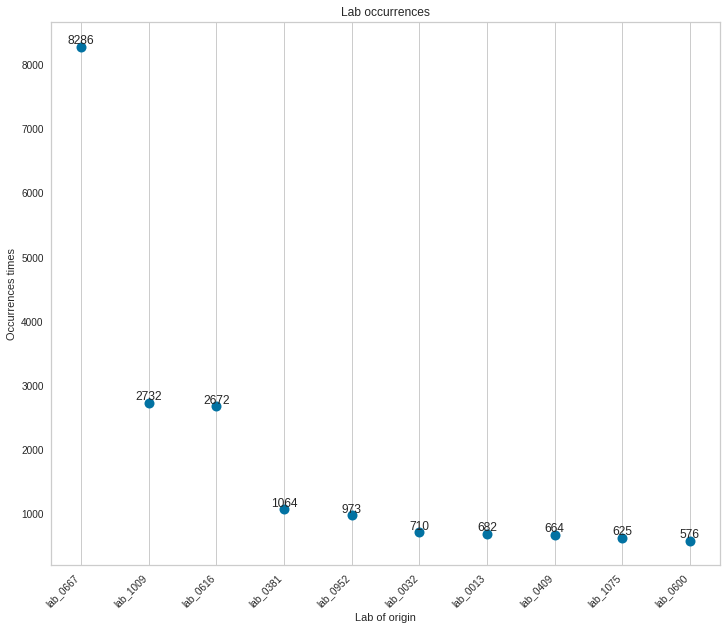

In [43]:
# Use argsort to get the indices that would sort the array in ascending order
sorted_indices = np.argsort(occurrences)

# Get the indices of the top 10 maximum values (last 10 indices after sorting in ascending order)
top_10_indices = sorted_indices[-10:]

# Rearrange the data in descending order
top_10_indices = top_10_indices[::-1]

output_columns_num = output_columns.map(lab_num_mapping)
# Create the dot plot
plt.figure(figsize=(12, 10))
plt.plot(output_columns_num[top_10_indices], occurrences[top_10_indices], 'o', markersize=10)
plt.xlabel('Lab of origin')
plt.ylabel('Occurrences times')
plt.title('Lab occurrences')

# Rotate the x-labels
plt.xticks(rotation=45, ha='right')

# Add the values to each dot
for i in top_10_indices:
    plt.text(output_columns_num[i], occurrences[i], str(occurrences[i])[:-2], ha='center', va='bottom')


plt.grid(axis='y')  # Add gridlines on the y-axis
plt.show()

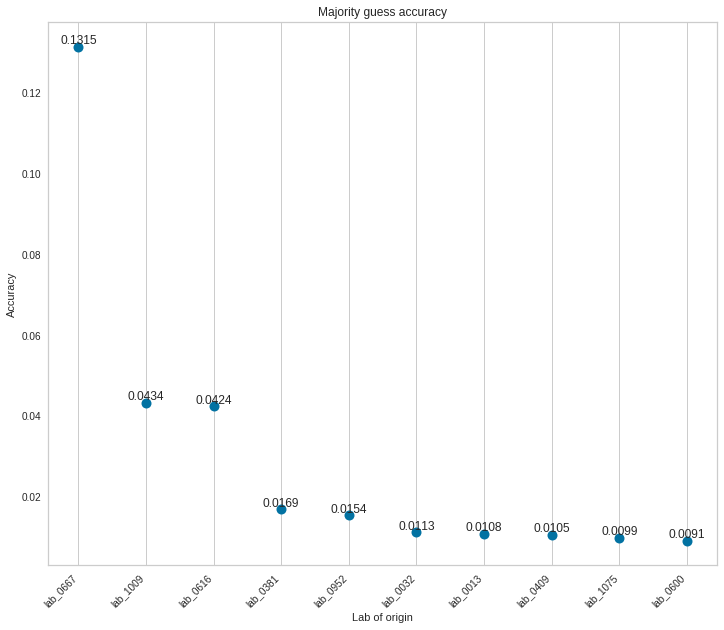

In [44]:
num_training = train_labels_df.shape[0]

# Create the dot plot
plt.figure(figsize=(12, 10))
plt.plot(output_columns_num[top_10_indices], occurrences[top_10_indices]/num_training, 'o', markersize=10)
plt.xlabel('Lab of origin')
plt.ylabel('Accuracy')
plt.title('Majority guess accuracy')

# Rotate the x-labels
plt.xticks(rotation=45, ha='right')

# Add the values to each dot
for i in top_10_indices:
    plt.text(output_columns_num[i], occurrences[i]/num_training, format(occurrences[i]/num_training,'.4f'), ha='center', va='bottom')


plt.grid(axis='y')  # Add gridlines on the y-axis
plt.show()

In [18]:
max_occurrences = np.max(occurrences)
min_occurrences = np.min(occurrences)
num_training = train_labels_df.shape[0]
max_guess_accuracy = format(max_occurrences/num_training,'.6f')
min_guess_accuracy = format(min_occurrences/num_training,'.6f')
display(f'The majority guess accuracy is between {min_guess_accuracy} and {max_guess_accuracy}')

'The majority guess accuracy is between 0.000016 and 0.131488'

In [19]:
# # Maybe we do not need this top-10 accuracy
# # Use argsort to get the indices that would sort the array in ascending order
# sorted_indices = np.argsort(occurrences)

# # Get the indices of the top 10 maximum values (last 10 indices after sorting in ascending order)
# top_10_indices = sorted_indices[-10:]

# # Use these indices to get the top 10 maximum values
# top_10_max_values = occurrences[top_10_indices]

# random_guess_accuracy_top10 = format(np.sum(top_10_max_values)/num_training,'.4f')
# display(f"The highest top-10 accuracy (if we always choose the lab with most sequences) can reach {random_guess_accuracy_top10}")
# # display(top_10_max_values)

In [20]:
# pub_best_sub = df.reset_index()[df.reset_index().index.isin(pub_index)]
# private_best_sub = df.reset_index()[df.reset_index().index.isin(private_index)]


# test_set has been encoded with one-hot encoding and give us the ground truth
private_test = test_set_sampled[test_set_sampled.index.isin(private_index)]
public_test = test_set_sampled[test_set_sampled.index.isin(pub_index)]
private_labels = private_test.drop(columns="sequence_id").values.argmax(axis=1)
public_labels = public_test.drop(columns="sequence_id").values.argmax(axis=1)

# TODO: private_best_sub and private_labels shape unmatch, pub_best_sub and public_labels shape unmatch

# top_10_score_private = top_k_accuracy_score(private_labels, private_best_sub.drop(columns="sequence_id").values, k=10, labels=range(0,1314))

# top_1_score_private = top_k_accuracy_score(private_labels, private_best_sub.drop(columns="sequence_id").values, k=1, labels=range(0,1314))

# top_10_score_public = top_k_accuracy_score(public_labels, pub_best_sub.drop(columns="sequence_id").values, k=10, labels=range(0,1314))

# top_1_score_public = top_k_accuracy_score(public_labels, pub_best_sub.drop(columns="sequence_id").values, k=1, labels=range(0,1314))

# top_10_score_total = top_k_accuracy_score(test_set.drop(columns="sequence_id").values.argmax(axis=1), df.reset_index().drop(columns="sequence_id").values, k=10, labels=range(0,1314))

# top_1_score_total = top_k_accuracy_score(test_set.drop(columns="sequence_id").values.argmax(axis=1), df.reset_index().drop(columns="sequence_id").values, k=1, labels=range(0,1314))

top_10_score_total = top_k_accuracy_score(test_set_sampled.drop(columns="sequence_id").values.argmax(axis=1), df.drop(columns="sequence_id").values, k=10, labels=range(0,1314))

top_1_score_total = top_k_accuracy_score(test_set_sampled.drop(columns="sequence_id").values.argmax(axis=1), df.drop(columns="sequence_id").values, k=1, labels=range(0,1314))


# display(f"Softmax model top-10 private score: {top_10_score_private}")

# display(f"Softmax model top-1 private score: {top_1_score_private}")

# display(f"Softmax model top-10 public score: {top_10_score_public}")

# display(f"Softmax model top-1 public score: {top_1_score_public}")

display(f"Softmax model top-10 total score: {top_10_score_total}")

display(f"Softmax model top-1 total score: {top_1_score_total}")

'Softmax model top-10 total score: 0.9'

'Softmax model top-1 total score: 0.8'

In [21]:
df.to_csv(f"{RESULTS_PATH}softmax_predictions.csv")

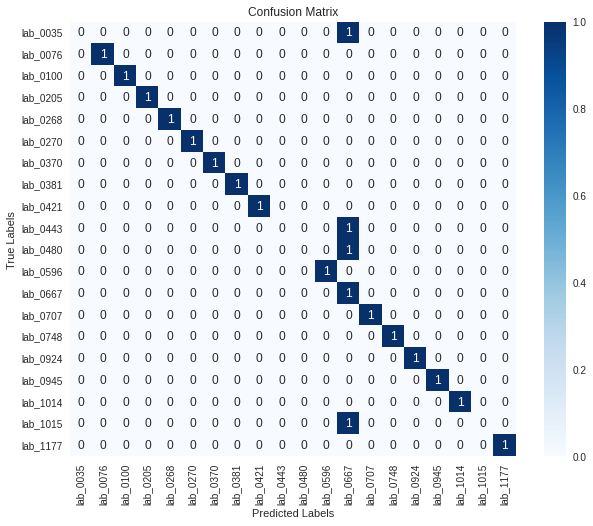

In [49]:
# confusion matrix (less than 20 samples could be a good plot to use)
# Replace these lists with your true and predicted labels
true_labels = result['lab_of_origin']
predicted_labels = [i[0][0][0] for _, i in sorted_columns.iterrows()]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Set labels for the matrix
labels = np.unique(np.union1d(predicted_labels, true_labels))
tick_labels = [label for label in labels]
col_labels = [label for label in labels]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=col_labels, yticklabels=tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Calibration (not working right now, because we sampled too little data

In [60]:
# # Extract the ground truth labels (you may have this from your data)
# # For example, if your ground truth labels are in a separate DataFrame column:
# # y_true = df['Ground_Truth_Label'].values
# y_true = result['lab_of_origin'].values  # Replace with your actual ground truth labels

# # Extract the predicted probabilities (excluding the Sequence ID column)
# # Here, we assume that the class columns start from the second column (index 1)
# y_probs = df.iloc[:, 1:].values

# # Number of classes
# num_classes = y_probs.shape[1]

# # Calculate the calibration curve for each class
# prob_true_by_class = []
# prob_pred_by_class = []

# for class_idx in range(num_classes):
#     class_probs = y_probs[:, class_idx]
#     prob_true, prob_pred = calibration_curve(y_true=y_true == class_idx, y_prob=class_probs, n_bins=10)
#     prob_true_by_class.append(prob_true)
#     prob_pred_by_class.append(prob_pred)

# # Plot the calibration curves for each class
# plt.figure(figsize=(8, 8))
# for class_idx in range(num_classes):
#     plt.plot(prob_pred_by_class[class_idx], prob_true_by_class[class_idx],
#              marker='o', linestyle='-', label=f'Class {class_idx+1}')

# # Add the diagonal line (perfect calibration)
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Perfect Calibration')

# plt.xlabel('Mean Predicted Probability')
# plt.ylabel('Fraction of Positives')
# plt.title('Calibration Plot (Per Class)')
# plt.legend()
# plt.show()


## Model 2: CNN + triplet


In [50]:
os.chdir('/home/jovyan/Gene-Technology-HS2023/code')

In [51]:
triplet_model_paths = list(sorted(glob("../data/output/daaefeed-3f3f-43a0-b7c2-2abf04e31e72/tensorboard_logs_csv_logs/*/checkpoints/*.ckpt")))
lab_index_mapping_paths = list(sorted(glob("../data/output/daaefeed-3f3f-43a0-b7c2-2abf04e31e72/tensorboard_logs_csv_logs/*/lab_index_mapping.pkl")))
from altlabs.model.conv1d_triplet_classifier import Conv1dTripletClassifier, ModelConfig

In [52]:
os.chdir('/home/jovyan/Gene-Technology-HS2023/data')

In [53]:
%%time
seed_everything(350)

def predict_dataset(model: Conv1dTripletClassifier, dataset: FactorizationDataset, tta_steps: int) -> np.ndarray:
    batch_sampler = FasterBatchSampler(
        dataset, 32, shuffle=False,
    )

    model.to(device)

    predictions: List[List[float]] = []
    with torch.no_grad():
        for indices in batch_sampler:
            if tta_steps > 0:
                tta_predictions = []
                for i in range(tta_steps):
                    batch = dataset[indices]
                    if isinstance(batch[0], tuple):
                        (sequences, extra_inputs, _) = batch[
                            0
                        ]  # type: (torch.Tensor, torch.Tensor, torch.Tensor)
                    else:
                        (sequences, extra_inputs) = batch
                    outputs = model.predict_lab_scores(
                        sequences.to(device), extra_inputs.to(device)
                    ).tolist()
                    tta_predictions.append(np.array(outputs))
                predictions.extend(
                    np.mean(np.array(tta_predictions), axis=0).tolist()
                )
            else:
                batch = dataset[indices]
                if isinstance(batch[0], tuple):
                    (sequences, extra_inputs, _) = batch[
                        0
                    ]  # type: (torch.Tensor, torch.Tensor, torch.Tensor)
                else:
                    (sequences, extra_inputs) = batch
                outputs = model.predict_lab_scores(
                    sequences.to(device), extra_inputs.to(device)
                ).tolist()
                predictions.extend(outputs)

    return np.array(predictions)


In [54]:
sequence_index_mapping = create_index_mapping(
"ATGC", include_unkown=True, include_none=False,
)
sequence_index_mapping["N"] = 0
input_columns = train_values_df.drop(columns=["sequence_id", "groups", "output"]).columns

In [55]:
fold_output = []
for triplet_model_path, lab_index_mapping_path in zip(triplet_model_paths, lab_index_mapping_paths):
    model = Conv1dTripletClassifier.load_from_checkpoint(triplet_model_path)
    with open(lab_index_mapping_path, "rb") as f:
        lab_index_mapping = pickle.load(f)
        
    dataset = FactorizationDataset(
        test_values_df_sampled,
        sequence_index_mapping,
        lab_index_mapping,
        input_columns,
        lab_column="output",
        negative_proportion=0.0,
        transform_sequence_fn=random_roll,
        test=True,
        bpe=True,
    )

    outputs = predict_dataset(model, dataset, 10)
    fold_output.append(outputs)
    # break
    
final_outputs = np.mean(fold_output, axis=0)


#### A problem found in the code: lab_index_mapping misses two labs

In [56]:
# why the lab_index_mapping is not of the shape we want, and miss two labs
[col for col in test_set_sampled.columns if col not in lab_index_mapping.keys()]
# the problem is caused by lab_index_mapping (it only have 1312 mapping relationship but we have 1314 in total)

['sequence_id', '0L3Y6ZB2', 'ON9AXMKF']

In [57]:
display(np.sum(test_set['0L3Y6ZB2']))
display(np.sum(test_set['ON9AXMKF']))

12.0

55.0

In [58]:
format_df_sampled = format_df.iloc[test_set_sampled.index]

In [59]:
# use the final_outputs[:,0] to fill the inference of ['0L3Y6ZB2', 'ON9AXMKF']
for lab in format_df_sampled.columns[1:]:
    lab_index = lab_index_mapping[lab]
    if lab == 'ZT1IP3T6':
        display(lab_index)
    format_df_sampled[lab] = final_outputs[:, lab_index]

format_df_sampled = format_df_sampled.round(6)

1305

In [60]:
pub_best_sub = format_df_sampled[format_df_sampled.index.isin(pub_index)]
private_best_sub = format_df_sampled[format_df_sampled.index.isin(private_index)]
private_test = test_set_sampled[test_set_sampled.index.isin(private_index)]
public_test = test_set_sampled[test_set_sampled.index.isin(pub_index)]
private_labels = private_test.drop(columns="sequence_id").values.argmax(axis=1)
public_labels = public_test.drop(columns="sequence_id").values.argmax(axis=1)

# top_10_score_private = top_k_accuracy_score(private_labels, private_best_sub.drop(columns="sequence_id").values, k=10, labels=range(0,1314))

# top_1_score_private = top_k_accuracy_score(private_labels, private_best_sub.drop(columns="sequence_id").values, k=1, labels=range(0,1314))

# top_10_score_public = top_k_accuracy_score(public_labels, pub_best_sub.drop(columns="sequence_id").values, k=10, labels=range(0,1314))

# top_1_score_public = top_k_accuracy_score(public_labels, pub_best_sub.drop(columns="sequence_id").values, k=1, labels=range(0,1314))

top_10_score_total = top_k_accuracy_score(test_set_sampled.drop(columns="sequence_id").values.argmax(axis=1), format_df_sampled.drop(columns="sequence_id").values, k=10, labels=range(0,1314))

top_1_score_total = top_k_accuracy_score(test_set_sampled.drop(columns="sequence_id").values.argmax(axis=1), format_df_sampled.drop(columns="sequence_id").values, k=1, labels=range(0,1314))



# display(f"Triplet model top-10 private score: {top_10_score_private}")

# display(f"Triplet model top-1 private score: {top_1_score_private}")


# display(f"Triplet model top-10 public score: {top_10_score_public}")

# display(f"Triplet model top-1 public score: {top_1_score_public}")

display(f"Triplet model top-10 total score: {top_10_score_total}")

display(f"Triplet model top-1 total score: {top_1_score_total}")



'Triplet model top-10 total score: 0.95'

'Triplet model top-1 total score: 0.75'

In [61]:
format_df_sampled.to_csv(f"{RESULTS_PATH}triplet_predictions.csv", index=False)

### 7. Compare results

In [66]:
# Find the column with the maximum value for each row
format_df_sampled_copy = format_df_sampled.copy()
format_df_sampled_copy.rename(columns=new_column_names, inplace=True)
# format_df_sampled_copy
max_columns = format_df_sampled_copy.drop(columns='sequence_id').idxmax(axis=1)

# Create a new DataFrame combining 'sequence_id' and the column names
result = pd.DataFrame({
    'sequence_id': test_set_sampled_copy['sequence_id'],
    'lab_of_origin': max_columns
})

# Display the result
display(result)

,sequence_id,lab_of_origin
8310,WZAMN,lab_0270
17684,UNQVV,lab_0924
5222,0UZOL,lab_1177
12559,UMLP9,lab_0381
10986,IPFNO,lab_0667
2425,0348B,lab_1171
9703,0261R,lab_0370
5833,CJLTL,lab_0100
17623,O4J10,lab_0667
12881,0VP4N,lab_0667


In [68]:
# Exclude the 'sequence_id' column from sorting
sort_columns = [col for col in format_df_sampled_copy.columns if col != 'sequence_id']

# Sort columns for each row and keep top ten columns
sorted_columns = df.apply(lambda row: sorted(zip(row[sort_columns].index, row[sort_columns]), key=lambda x: x[1], reverse=True)[:10], axis=1)
# sorted_columns = sorted_columns.reset_index().drop(columns='index')
sorted_columns = pd.DataFrame(sorted_columns)

# Create a figure and axes
fig, axes = plt.subplots(sorted_columns.shape[0], 1, figsize=(6, sorted_columns.shape[0]*3))

# Iterate over each row and create a separate plot
for idx,(index , sorted_vals) in enumerate(sorted_columns.iterrows()):
    # display(sorted_vals)
    
    sequence_id = format_df_sampled.loc[index, 'sequence_id']
    
    sorted_val = sorted_vals[0]
    
    columns, values = zip(*sorted_val)
    
    # Get the appropriate subplot from the axes
    ax = axes[idx]
    
    # Plot the values
    bars = ax.bar(columns, values, width=0.5)
    
    # Set the title as the sequence_id
    ax.set_title('Sequence id:'+sequence_id)
    
    # Rotate x-axis labels for better readability
    ax.set_xticklabels(columns, rotation=45)
    
    ax.set_ylabel('Probability')
    ax.set_xlabel('Lab of origin')
    ax.grid(False)
    ax.set_ylim(0,1)
    
    # Add value annotations on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.3f}', ha='center', va='bottom')
    
    
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

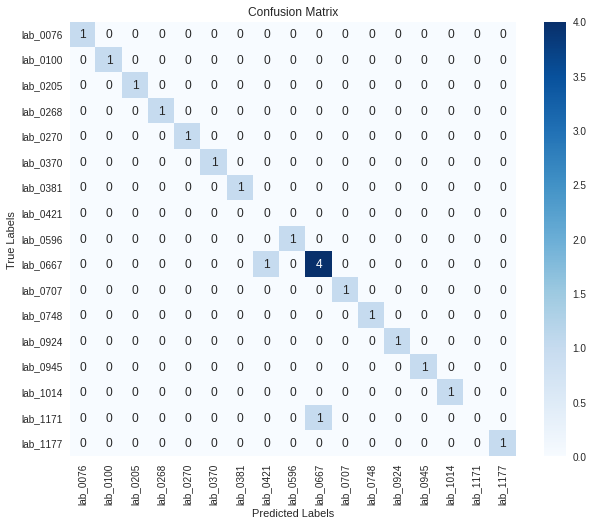

In [69]:
# confusion matrix (less than 20 samples could be a good plot to use)
# Replace these lists with your true and predicted labels
true_labels = result['lab_of_origin'].values
predicted_labels = [i[0][0][0] for _, i in sorted_columns.iterrows()]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Set labels for the matrix
labels = np.unique(np.union1d(predicted_labels, true_labels))
tick_labels = [label for label in labels]
col_labels = [label for label in labels]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=col_labels, yticklabels=tick_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()